In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
# from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [3]:
testdata=pd.read_parquet('dataset/UNSW_NB15_testing-set.parquet')

In [7]:
# Display basic information about the dataset first to understand the structure
print("\n--- Dataset Info ---")
print(f"Shape: {testdata.shape}")
print(f"Columns: {testdata.columns.tolist()}")
print(f"Data types: \n{testdata.dtypes}")
print(f"Class distribution (label column):")
print(testdata.iloc[:, 35].value_counts())


--- Dataset Info ---
Shape: (82332, 36)
Columns: ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'attack_cat', 'label']
Data types: 
dur                   float32
proto                category
service              category
state                category
spkts                   int16
dpkts                   int16
sbytes                  int32
dbytes                  int32
rate                  float32
sload                 float32
dload                 float32
sloss                   int16
dloss                   int16
sinpkt                float32
dinpkt                float32
sjit                  float32
djit                  float32
swin                  

In [8]:
# Identify categorical and numerical columns
# You may need to adjust these based on your dataset's specific columns
categorical_columns = []
numerical_columns = []

# Check each column to identify categorical features
for col in testdata.columns[:-1]:  # Exclude the target column
    if testdata[col].dtype == 'object' or testdata[col].nunique() < 10:
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

print(f"\nCategorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")


Categorical columns: ['state', 'trans_depth', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports']
Numerical columns: ['dur', 'proto', 'service', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'attack_cat']


In [20]:
# Let's manually define the categorical and numerical columns based on your info
categorical_columns = ['proto', 'service', 'state', 'trans_depth', 'is_ftp_login', 
                       'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports']
# attack_cat
numerical_columns = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 
                    'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 
                    'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 
                    'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 
                    'ct_dst_sport_ltm']

print(f"\nManually defined categorical columns: {categorical_columns}")
print(f"Manually defined numerical columns: {numerical_columns}")


Manually defined categorical columns: ['proto', 'service', 'state', 'trans_depth', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports']
Manually defined numerical columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm']


In [23]:
# Preprocessing function
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Preprocessing function
def preprocess_data(data):
    # Separate features and target
    X = data.iloc[:, :35]  # Feature columns
    y = data.iloc[:, 35].values  # Label column
    
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('normalizer', Normalizer())
            ]), numerical_columns),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
            ]), categorical_columns)
        ],
        remainder='drop'  # Drop any columns not specified
    )
    
    # Apply preprocessing
    X_processed = preprocessor.fit_transform(X)
    print(f"Processed data shape: {X_processed.shape}")
    
    # Reshape for CNN-LSTM model
    X_reshaped = np.reshape(X_processed, (X_processed.shape[0], X_processed.shape[1], 1))
    
    return X_processed, X_reshaped, y, preprocessor

# Apply preprocessing
X_processed, X_reshaped, y, preprocessor = preprocess_data(testdata)

Processed data shape: (82332, 201)


In [27]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (65865, 201, 1)
Validation data shape: (16467, 201, 1)


In [28]:
# Build the model
print("\nBuilding CNN-LSTM model...")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Adjust input shape based on preprocessed data
input_shape = (X_train.shape[1], 1)

model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', 
                input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(70))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Building CNN-LSTM model...


c:\Users\Liberty\OneDrive\Desktop\iot project\anomaly_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Define callbacks
checkpoint = ModelCheckpoint(
    "new_anomaly_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Training the model...
Epoch 1/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7236 - loss: 0.5060
Epoch 1: val_accuracy improved from -inf to 0.79310, saving model to new_anomaly_model.keras
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 141s 127ms/step - accuracy: 0.7237 - loss: 0.5059 - val_accuracy: 0.7931 - val_loss: 0.3774
Epoch 2/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7966 - loss: 0.3774
Epoch 2: val_accuracy improved from 0.79310 to 0.79450, saving model to new_anomaly_model.keras
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - accuracy: 0.7966 - loss: 0.3774 - val_accuracy: 0.7945 - val_loss: 0.3734
Epoch 3/15
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7988 - loss: 0.3703
Epoch 3: val_accuracy did not improve from 0.79450
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 140s 121ms/step - accuracy: 0.7988 - loss: 0.3703 - val_accuracy: 0.7916 - val_loss: 0.3749
Epoch 4/15
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7994 - loss: 0.3687
Epoch 4:

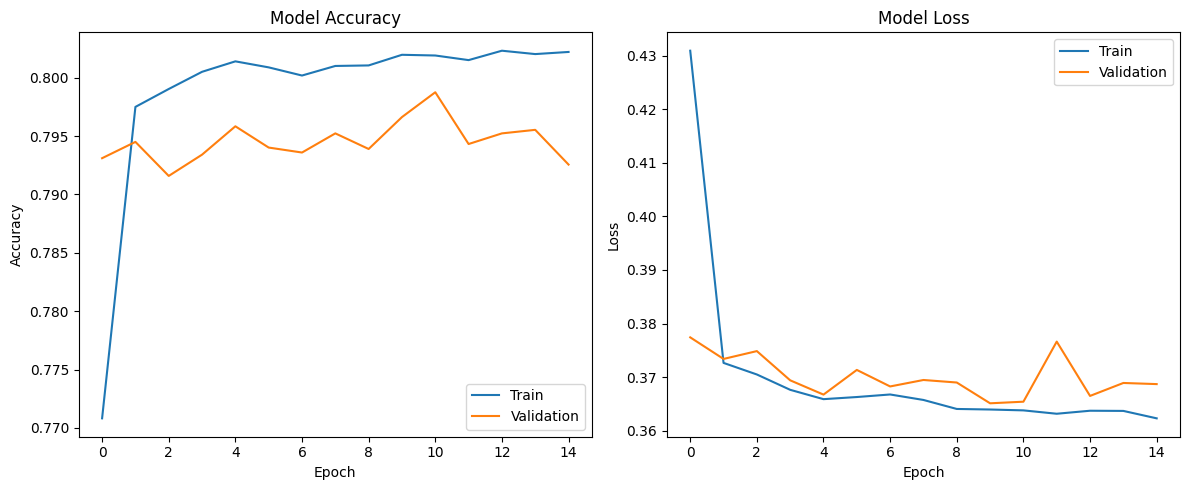

In [34]:
# Plot training history
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [35]:
# Evaluate on the test set
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the model on the test set...
515/515 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8016 - loss: 0.3625
Test Loss: 0.3654
Test Accuracy: 0.7987


In [36]:
# Make predictions
from sklearn.metrics import classification_report, confusion_matrix

print("\nGenerating predictions and metrics...")
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate performance metrics
print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred_binary)
print(cm)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\nDetailed Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")


Generating predictions and metrics...


515/515 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      7400
           1       0.94      0.68      0.79      9067

    accuracy                           0.80     16467
   macro avg       0.82      0.81      0.80     16467
weighted avg       0.84      0.80      0.80     16467


Confusion Matrix:
[[7015  385]
 [2929 6138]]

Detailed Metrics:
True Negatives: 7015
False Positives: 385
False Negatives: 2929
True Positives: 6138
Precision: 0.9410
Recall: 0.6770
F1 Score: 0.7874
Accuracy: 0.7987


In [37]:
# Save the model
model.save("unsw_nb15_anomaly_detector.keras")
print("\nModel saved as 'unsw_nb15_anomaly_detector.keras'")


Model saved as 'unsw_nb15_anomaly_detector.keras'
